# Eigendecomposition of the Iris dataset

In EOF analysis, we seek a solution to the following equation.  For a matrix **A** we seek a set of vectors $\mathbf{V}$ which makes the following equation true:

$A\mathbf{V} = \Lambda \mathbf{V}$

$\mathbf{V}$ are called the _**eigenvectors**_ and $\Lambda$ contains values ($\lambda$) along the diagonal called _**eigenvalues**_.  The equation tells us that we may be able to find a new set of (eigen)vectors for which the values in our data matrix **A** can be expressed simply as a magnitude along these new eigenvectors.  As we discussed in class, if **A** is a square symmetric matrix _m x m_ like the covariance matrix, the _m_ eigenvalues are all real and positive and the eigenvectors that are paired to these eigenvalues are orthogonal.  It is these pairs of _m_ eigenvalues and their respective eigenvectors that we are after in EOF analysis of our datasets.

So what's so cool about eigenvectors and eigenvalues?  First, eigenvalues give us some indication of how the common patterns of variance are re-distributed into the new eigenvectors.  If we call each eigenvector and eigenvalue pair a **mode** then for each mode the eigenvalue can tell you how much of the total variance in the original data is captured by the new eigenvector associated with it. The eigenvectors are also *orthogonal* to one another, which means that they are independent from one another (something that is useful for regression modeling, for instance).  Finally, when the eigenvectors are projected (multiplied) onto the original centered data, they produce new a data series the size of the original data series but that are now uncorrelated with one another and related to the pattern present in the eigenvector.  

However, before we get to more complex examples using spatiotemporal data and how to interpret eigenvalues and eigenvectors in those contexts, let's take a look at a simple example with the Iris dataset you used in Homework #1:


This short notebook will walk you through the basics of the simple Iris 2-dimensional empirical orthogonal function calculation. 

Let's first import our packages:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'

We'll read in the Iris data (same data you used on Homework #1) and take a look at the resulting DataFrame::

In [3]:
df = pd.read_csv('iris.data') # use Pandas to read in the csv data
df #let's look at our Pandas dataframe


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species(id)
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica



In the code block below, we'll create a new DataFrame with only the sepal length and sepal width from Iris setosa.  For this we'll use Pandas `.loc` with a long chain of specifics.  Note that the species selection (rows) and columns are in the square backets of the `.loc` method - so the row selection uses the `.str.contains` applied to the species id column, and then the column selection is the two sepal related columns, enclosed together in square brackets.  The `.copy()` at the end ensures that sepal going forward will be not affected by any changes to the original df. 

In [5]:

sepal = df.loc[df[" species(id)"].str.contains('Iris-setosa'), ["sepal length (cm)"," sepal width (cm)"]].copy()
sepal # take a look:


,sepal length (cm),sepal width (cm)
0,5.1,3.5
1,4.9,3.0
2,4.7,3.2
3,4.6,3.1
4,5.0,3.6
5,5.4,3.9
6,4.6,3.4
7,5.0,3.4
8,4.4,2.9
9,4.9,3.1


We now have a new Pandas DataFrame with 50 rows and 2 columns. Let's scatter plot the data using Pandas object plotting ability.  To do this we tell Pandas the column name of the x and y values, and we can also pass it some plotting options.  The second line tries to set the aspect of the plot to be equal in both x and y directions:

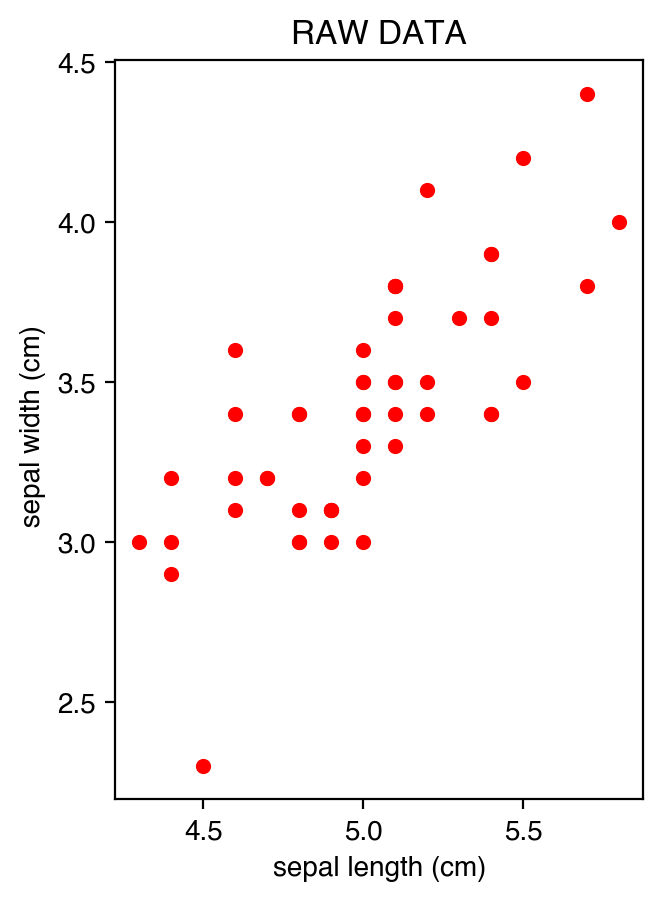

In [6]:
sx1 = sepal.plot.scatter(x="sepal length (cm)",y=" sepal width (cm)",color='Red',title='RAW DATA')
sx1.set_aspect('equal', 'box')


We'll now calculate the covariance of these two measurements.  There are (at least) two ways to do this.  In the first way, we turn our Pandas DataFrame into a simple NumPy array using `.to_numpy()`.  We then remove the mean of the data columns (we'll see why in a moment) and calculate the covariance using Numpy's `np.cov`.  Note that we pass [two additional inputs to `np.cov`](https://numpy.org/doc/stable/reference/generated/numpy.cov.html).  First, `rowvar=False` tells NumPy that our variables are in columns and the observations of those variables are in rows (the default in NumPy is the reverse).  Second, we still need `ddof=1` to get the unbiased covariance. 

Alternatively, we could get the covariance directly from Pandas, using the [`.cov` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.cov.html). 

In [7]:
# take Pandas dataframe, put into NumPy array, remove mean, calculate covariance
sepal_array = sepal.to_numpy()
sepal_array = sepal_array - sepal_array.mean(axis=0)

# covariance from array 
Cn = np.cov(sepal_array,rowvar=False,ddof=1)

# or keep in datafrom, calculate covariance, then move Covariance to NumPy array
Cp = pd.DataFrame(sepal).cov(ddof=1)

print(Cn)
Cp


[[0.12424898 0.10029796]
 [0.10029796 0.14517959]]


,sepal length (cm),sepal width (cm)
sepal length (cm),0.124249,0.100298
sepal width (cm),0.100298,0.145180


Compare the results from the two methods and convince yourself you understand how the two approaches work to calculate the covariance matrix. 

Now that we have our covariance matrix, we can calculate the eigenvalues and eigenvectors -- we'll do our first Singular Value Decomposition (svd)!  As usual, there are several ways to do this.  Numpy has `np.linalg.svd` which will calculate the complete SVD of the covariance matrix.  This will work OK for now, since our dataset and covariance matrix are quite small.  Alternatively, SciPy provide `sp.sparse.linalg.svds` where you can specify how many eigenvalue/eigenvector pairs to calculate.  This can be much, much faster for datasets with a large number of variables. 

Singular value decomposition of a square symmetric matrix allows us to factorize the covariance matrix to the product of matrices containing the eigenvalues and eigenvectors:

$$
\mathbf{A} = \mathbf{Q} \Lambda \mathbf{Q}^{T}
$$

Where **Q** contains the eigenvectors and $\Lambda$ is a diagonal matrix containing the eigenvalues, $\lambda$.  

We'll more typically use a notation like this (more on this later):

$$
\mathbf{A} = \mathbf{U} \Sigma \mathbf{V}^{T}
$$

We'll use NumPy here, since our data are a manageable size:

In [8]:
# do the SVD
U, S, V = np.linalg.svd(Cn) # could use Cp or Cn

The output contains U and V with the eigenvectors and S with the eigenvalues.  Let's take a look at S first:

In [9]:
# The eigenvalues are in S
print(Cn)
print(S)


[[0.12424898 0.10029796]
 [0.10029796 0.14517959]]
[0.23555675 0.03387182]


Unlike other programming languages, `np.linalg.svd` returns S as an array instead of a diagonal matrix, so the total variance in the system is the sum of the elements of S:

In [10]:
total_variance_original = np.sum(np.var(sepal_array,axis=0,ddof=1))
total_variance_svd = np.sum(S)
total_variance_original, total_variance_svd # same total variance


(np.float64(0.26942857142857146), np.float64(0.2694285714285714))

Next, let's look at U and V, the matrices we expect to hold the eigenvectors:

In [12]:
print(U)
print(V)


[[-0.66941065 -0.74289258]
 [-0.74289258  0.66941065]]
[[-0.66941065 -0.74289258]
 [-0.74289258  0.66941065]]


Notice that in this simple case, U == V, but also because this is 2 variable case that U.T == V as well.  My warning to you is that, generally speaking but especially in Python, be sure you know whether the columns or rows of the method or function you are using contain the eigenvectors.  In more complex cases, the answer may different substantially. 

Let's check if the columns of U are orthongonal.  Remember that we can check for orthogonality from the dot products our two vectors: 

In [13]:
print(np.dot(U[:,0],U[:,1]))

-1.3183939343219683e-16


Orthogonal? The number is 0 within floating point machine precision, so these vectors are orthongonal. 

Let's plot the original data and then the eigenvectors:

Text(-0.75, 0.79, '13.0%')

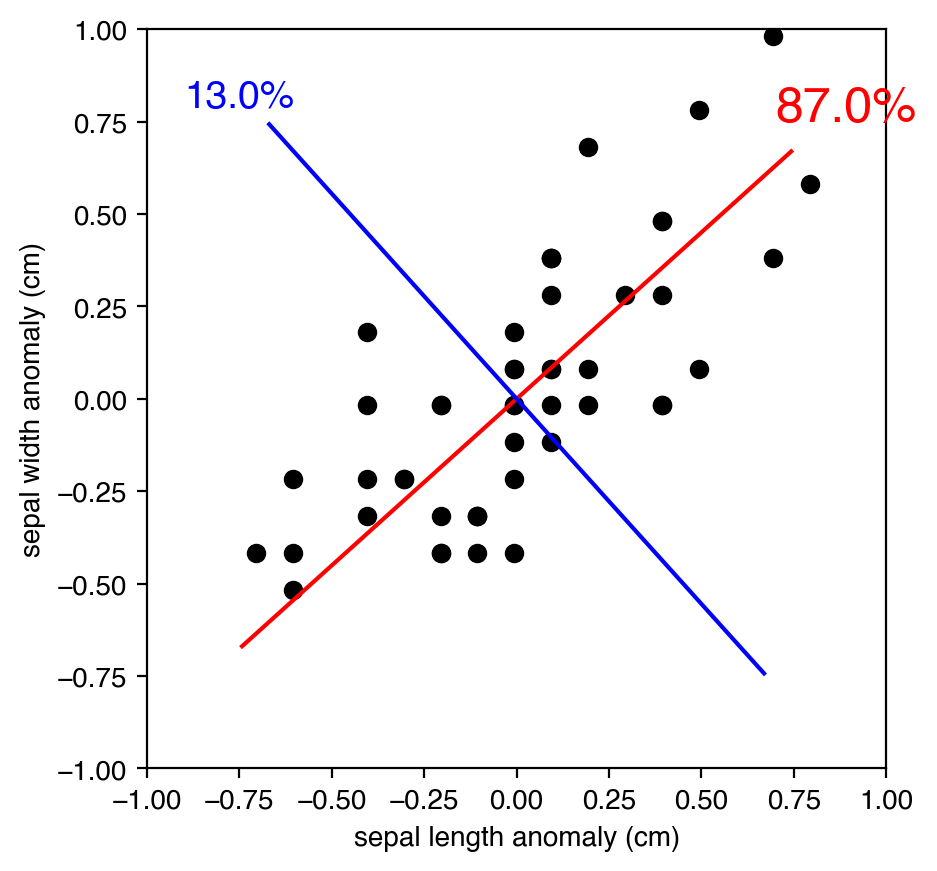

In [14]:
plt.figure()
ax = plt.axes()
ax.scatter(sepal_array[:,0],sepal_array[:,1],color='black')  # there are the center (zero mean) values
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_xlabel('sepal length anomaly (cm)')
ax.set_ylabel('sepal width anomaly (cm)')

# stretchLine = 1 # for display purposes

# the vector described by the first eigenvalue (column 0 of U)
lx1 = ax.plot([-U[1,0],U[1,0]],[-U[0,0],U[0,0]],color='red');

# the vector described by the first eigenvalue (column 1 of U)
lx2 = ax.plot([-U[1,1],U[1,1]], [-U[0,1],U[0,1]],color='blue');
ax.set_aspect('equal', 'box')

# the explained variance in percentage
expvar = np.round((S/np.sum(S)) * 100)

# place the explained variance for each new eigenvector on the plot
ax.text(0.70,0.75,f'{expvar[0]}%',fontsize=18,color='red')
ax.text(-0.75,0.79,f'{expvar[1]}%',fontsize=14,color='blue',horizontalalignment='center')

Notice too that each eigenvector is unit length:

In [15]:
print(np.linalg.norm(U[:,0]))
print(np.linalg.norm(U[:,1]))

1.0
1.0


We can demonstrate how the eigenvectors allow us to express the original data on the new 'axes' or basis that the eigenvectors provide.  Let's (matrix) multiply the eigenvectors and the original centered (zero mean) data -- this will project the original data into the space of the eigenvectors.   This essentially makes the eigenvectors the new axes for the data space

Text(0, 0.5, 'SECOND EIGENMODE')

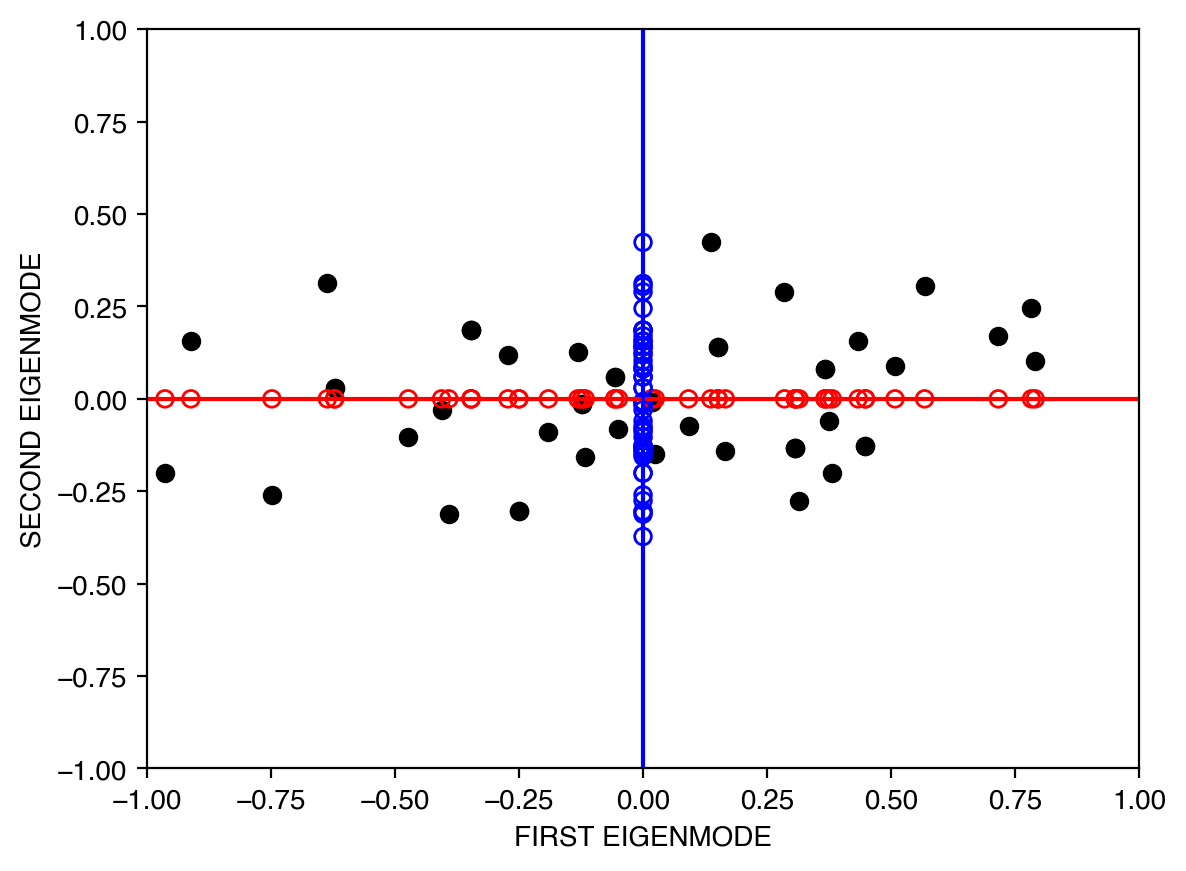

In [16]:
rot = U @ sepal_array.T

plt.figure()
ax = plt.axes()
ax.scatter(rot[0,:],rot[1,:],color='black')
ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.plot([-1,1],[0,0], color="red")
ax.scatter(rot[0,:],np.zeros(rot[0,:].shape),color='red',marker='o',facecolors='none')
ax.plot([0,0],[-1,1], color="blue")
ax.scatter(np.zeros(rot[1,:].shape),rot[1,:],color='blue',marker='o',facecolors='none')

ax.set_xlabel('FIRST EIGENMODE')
ax.set_ylabel('SECOND EIGENMODE')


In [18]:
np.var(sepal_array,axis=0)

array([0.121764, 0.142276])